# Joint Distributions

In this lab, we will implement a multilevel logistic regression model using the `tensorflow_probability`'s `JointDistribution` API.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
plt.style.use("ggplot")

tfd = tfp.distributions

2023-02-15 13:28:15.021355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 13:28:15.106212: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-15 13:28:15.106229: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-15 13:28:15.668431: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
## TEACHER
import inspect
import init; init.init(force_download=False); init.get_weblink()

In [3]:
## TEACHER
from local.lib.rlxmoocapi import submit, session
session.LoginSequence(
    endpoint=init.endpoint,
    course_id=init.course_id,
    lab_id="L04.01.03",
    varname="teacher"
    );

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We'll use the following synthetic dataset:

In [4]:
n_features = 2
n_classes = 3
X, y = make_blobs(
        n_samples=500,
        n_features=n_features,
        centers=n_classes,
        random_state=42
        )

We can visualize the data:

Text(0, 0.5, '$x_2$')

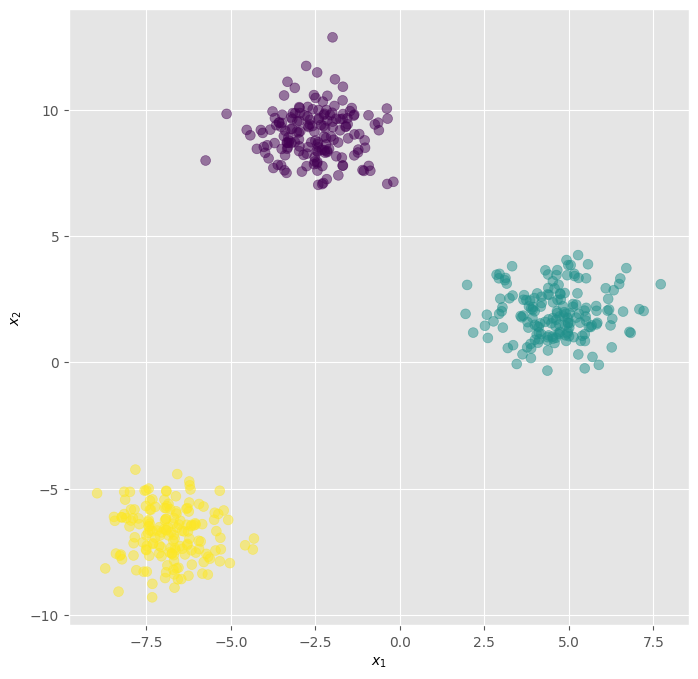

In [5]:
## KEEPOUTPUT
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="viridis", alpha=0.5)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

## Task 1: Logistic Regression
---

In this task, you must define a logistic regression model using the `JointDistributionNamed` API, you must implement the following model:

$$
w \sim \mathcal{N}([0, 0], [1, 1])\\
b \sim \mathcal{N}(0, 1)\\
\text{logits} = \mathbf{w}\cdot\mathbf{x} + b\\
y \sim \text{categorical}(\text{logits})
$$

The model must have the following distributions: `w`, `b`, and `y`:

In [6]:
def prob_log_regression(x, n_features, n_classes):
    # YOUR CODE HERE
    model = ...
    return model

In [7]:
## TEACHER
def prob_log_regression(x, n_features, n_classes):
    model = tfd.JointDistributionNamedAutoBatched({
        "w": tfd.Normal(loc=tf.zeros(shape=(n_features, n_classes)), scale=1.),
        "b": tfd.Normal(loc=tf.zeros(shape=(n_classes, )), scale=1.),
        "y": lambda b, w: tfd.Independent(
            tfd.Categorical(logits=x @ w + b),
            reinterpreted_batch_ndims=1
            )
        }
    )
    return model

You can use the model to generate samples:

In [9]:
## KEEPOUTPUT
model = prob_log_regression(X, n_features, n_classes)
samples = model.sample(1)
print(samples["y"].shape)

(1, 500)


In [10]:
## TEACHER
def grader1(functions, variables, caller_userid):
    import tensorflow as tf
    import tensorflow_probability as tfp
    tfd = tfp.distributions

    namespace = locals()
    for f in functions.values():
        exec(f, namespace)

    n_features = 2
    n_classes = 3
    n_samples = 500
    X, y = make_blobs(
            n_samples=n_samples,
            n_features=n_features,
            centers=n_classes,
            random_state=42
            )
    
    prob_log_regression = namespace["prob_log_regression"]
    model_student = prob_log_regression(X, n_features, n_classes)
    msg = "Validating probabilistic model...</br>"
    if not isinstance(model_student, tfd.JointDistribution):
        msg += "<b>Your model is not a joint distribution.</b></br>"
        return 0, msg


    dists = model_student.sample_distributions()[0]
    expected_dists = {
            "w": {
                "type": tfd.Normal,
                "batch_shape": [n_features, n_classes],
                "event_shape": []
                },
            "b": {
                "type": tfd.Normal,
                "batch_shape": [n_classes],
                "event_shape": []
                },
            "y": {
                "type": tfd.Independent,
                "batch_shape": [],
                "event_shape": [n_samples],
                }
            }
    for param, values in expected_dists.items():
        if param not in dists:
            msg += f"<b>Your model doesn't contain the distribution '{param}'</b></br>"
            return 0, msg
        if not isinstance(dists[param], values["type"]):
            msg += f"<b>The distribution '{param}' is incorrect.</b>"
            return 0, msg

        if list(dists[param].batch_shape) != values["batch_shape"]:
            msg += f"<b>The distribution '{param}' has a wrong batch_shape.</b>"
            return 0, msg

        if list(dists[param].event_shape) != values["event_shape"]:
            msg += f"<b>The distribution '{param}' has a wrong event_shape.</b>"
            return 0, msg

    return 5, msg + "<b>Success!</b>"

Use the following cell to grade your code:

In [11]:
## TEACHER
source_functions = ["prob_log_regression"]
source_variables = []
res = teacher.run_grader_locally("grader1", source_functions, source_variables, locals())
display(res)

In [12]:
teacher.set_grader(
        teacher.course_id, "L04.01.03", "T1",
        inspect.getsource(grader1), "grader1",
        source_functions, source_variables
        )

In [ ]:
student.submit_task(namespace=globals(), task_id="T1");

## Task 2: Markov Chain Monte Carlo
---

Implement the `mcmc` function to train the model, you must use a Markov Chain Monte Carlo Strategy, We recommend using the `NoUTurnSampler` but feel free to experiment with the sampler.

In [13]:
## TEACHER
@tf.function
def mcmc(
        model,
        y,
        n_features,
        n_classes,
        num_samples,
        burning_steps,
        step_size=1e-3
        ):
    def log_prob(w, b):
        return model.log_prob(w=w, b=b, y=y)
    kernel = tfp.mcmc.NoUTurnSampler(
            target_log_prob_fn=log_prob,
            step_size=step_size
            )
    
    return tfp.mcmc.sample_chain(
            num_results=num_samples,
            num_burnin_steps=burning_steps,
            current_state=[
                tf.ones(shape=(n_features, n_classes)),
                tf.ones(n_classes)
                ],
            kernel=kernel,
            trace_fn=lambda _, results: results.target_log_prob
            )

In [14]:
samples, log_probs = mcmc(
        model=model,
        y=y,
        n_features=n_features,
        n_classes=n_classes,
        num_samples=100,
        burning_steps=50,
        )

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Use the following cell to generate a visualization of the `log_probs`, it must look similar to:

> **Note: The results may vary but the log-probs range bust be similar to the figure, and the average, must be close.**

Text(0.5, 1.0, 'AVG Log Prob = -14.88')

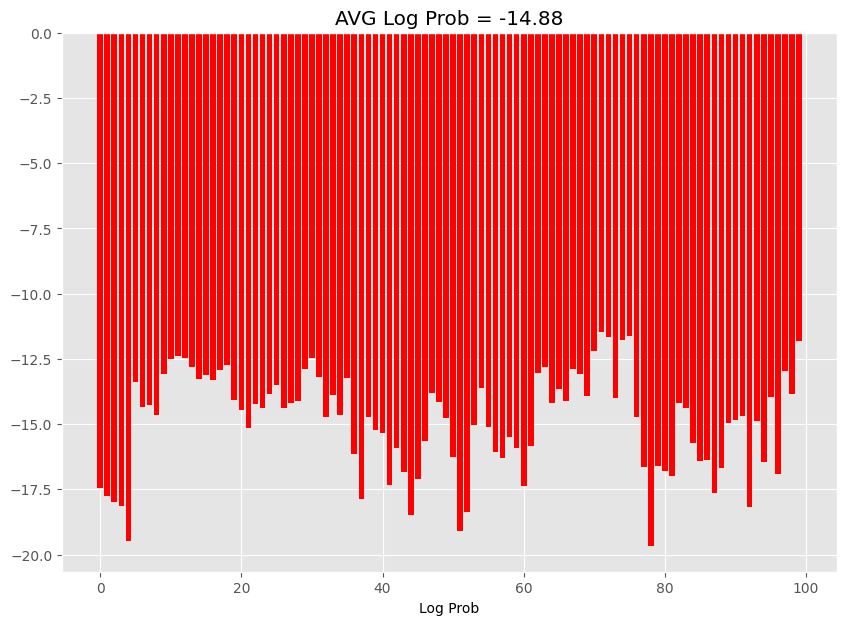

In [15]:
## KEEPOUTPUT
log_probs_viz = log_probs.numpy()
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.bar(np.arange(log_probs_viz.size), log_probs_viz, color="r")
ax.set_xlabel("Sample")
ax.set_xlabel("Log Prob")
ax.set_title(f"AVG Log Prob = {log_probs_viz.mean():.2f}") 

In [16]:
def grader2(functions, variables, caller_userid):
    import tensorflow as tf
    import numpy as np
    import tensorflow_probability as tfp

    tf.random.set_seed(0)
    tfd = tfp.distributions

    namespace = locals()
    for f in functions.values():
        exec(f, namespace)

    # compare descriptive stats using the same base model.

    n_features = 2
    n_classes = 2
    n_gen_samples = 100
    burnout = 100

    X = np.array([
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1]
        ] * 10, dtype="float32")
    y = {
            "and": np.array([0, 0, 0, 1] * 10),
            "or": np.array([0, 1, 1, 1] * 10),
            }

    mcmc = namespace["mcmc"]
    msg = "Validating mcmc procedure...</br>"

    for case, y_i in y.items():

        model = tfd.JointDistributionNamedAutoBatched({
            "w": tfd.Normal(loc=tf.zeros(shape=(n_features, n_classes)), scale=1.),
            "b": tfd.Normal(loc=tf.zeros(shape=(n_classes, )), scale=1.),
            "y": lambda b, w: tfd.Independent(
                tfd.Categorical(logits=X @ w + b),
                reinterpreted_batch_ndims=1
                )
            })
        samples, log_probs = mcmc(
                model=model,
                y=y_i,
                n_features=n_features,
                n_classes=n_classes,
                num_samples=n_gen_samples,
                burning_steps=burnout,
                )

        if samples[0].shape != tf.TensorShape([n_gen_samples, n_features, n_classes]):
            msg += "<b>Your function returns samples with wrong w shapes.</b></br>"
            return 0, msg

        if samples[1].shape != tf.TensorShape([n_gen_samples, n_classes]):
            msg += "<b>Your function returns samples with wrong b shapes.</b></br>"
            return 0, msg

        if log_probs.shape != tf.TensorShape([n_gen_samples]):
            msg += "<b>Your function returns log_probs with wrong shape.</b></br>"
            return 0, msg

        w = samples[0].numpy().mean(axis=0)
        b = samples[1].numpy().mean(axis=0)

        y_pred = np.argmax(X @ w + b, axis=1)

        if (y_pred == y_i).sum() / y_i.size < 0.9:
            msg += "<b>The mcmc function does not optimize the specified model.</b></br>"
            msg += str(y_pred)
            msg += str(y_i)
            return 0, msg

    return 5, msg + "<b>Success!</b>"

In [17]:
## TEACHER
source_functions = ["mcmc"]
source_variables = []
res = teacher.run_grader_locally("grader2", source_functions, source_variables, locals())
display(res)

In [18]:
## TEACHER
teacher.set_grader(
        teacher.course_id, "L04.01.03", "T2",
        inspect.getsource(grader2), "grader2",
        source_functions, source_variables
        )

In [ ]:
student.submit_task(namespace=globals(), task_id="T2");

## Task 3: Kernel Density Estimation
---

Compute the Maximum Aposteriori predictions of the parameters as follows:

$$
w_{map} = \text{argmax}(\text{kde}(w_{samples}))\\
b_{map} = \text{argmax}(\text{kde}(w_{samples}))\\
\hat{y} = \text{argmax}(\text{softmax}(X, w_{map}, b_{map}))
$$

You must use `KernelDensity` for the estimation of the MAP parameters.

In [19]:
def kde(w_samples, b_samples, x, kernel="gaussian", bandwidth=0.1):
    # YOUR CODE HERE
    preds = ...
    return preds

In [20]:
## TEACHER
def kde(w_samples, b_samples, x, kernel="gaussian", bandwidth=0.1):
    flat_w = w_samples.reshape(
            (-1, np.prod(w_samples.shape[1:]))
            )
    w_densities = (
            KernelDensity(kernel=kernel, bandwidth=bandwidth)
            .fit(flat_w)
            .score_samples(flat_w)
            )
    idx = np.argmax(w_densities)
    w_map = w_samples[idx]

    flat_b = b_samples.reshape(
            (-1, np.prod(b_samples.shape[1:]))
            )
    b_densities = (
            KernelDensity(kernel=kernel, bandwidth=bandwidth)
            .fit(flat_b)
            .score_samples(flat_b)
            )
    idx = np.argmax(b_densities)
    b_map = b_samples[idx]

    probs = tf.nn.softmax(x @ w_map + b_map)
    preds = np.argmax(probs, axis=1)
    return preds

Let's generate some predictions:

In [21]:
## KEEPOUTPUT
preds = kde(samples[0].numpy(), samples[1].numpy(), X)
print(preds)

[2 1 1 0 1 1 2 1 1 2 1 0 0 0 1 1 0 2 2 0 1 0 1 2 2 1 1 2 2 0 1 0 0 0 1 1 1
 1 2 2 1 0 0 0 0 1 1 1 1 2 2 0 2 2 1 0 0 2 1 2 2 0 1 2 1 2 1 2 0 1 1 1 1 2
 0 2 0 1 0 0 2 0 1 0 2 2 2 2 1 0 2 1 0 1 1 2 0 0 0 2 1 0 0 2 2 0 0 2 0 2 2
 2 2 2 2 1 0 2 1 2 0 0 1 1 2 1 0 1 2 2 2 1 1 2 1 2 2 2 1 0 2 2 1 1 2 2 2 0
 0 0 1 2 1 1 0 2 0 2 1 1 2 2 0 0 2 0 0 1 2 2 2 0 0 2 2 0 0 1 1 1 0 2 0 0 2
 2 0 1 0 2 2 2 2 2 0 1 0 0 2 1 0 0 2 2 1 2 1 0 0 2 2 1 2 0 0 2 0 2 0 1 1 0
 2 0 1 0 0 2 1 1 1 1 0 2 2 2 0 1 0 1 1 1 0 0 2 2 1 0 0 1 0 0 0 0 1 0 2 0 2
 0 0 0 2 0 1 1 1 0 1 1 0 0 1 2 0 0 0 0 2 2 0 1 0 0 2 0 1 2 1 1 2 0 0 0 2 0
 2 1 1 0 1 2 1 1 0 1 1 1 1 0 1 2 1 1 1 2 2 1 1 0 2 1 1 2 2 2 1 2 2 2 2 2 0
 2 0 2 0 0 2 0 1 1 0 0 1 0 1 0 1 1 1 0 1 2 2 1 2 0 1 0 1 0 1 1 2 0 1 1 0 2
 0 2 0 1 2 0 2 1 2 2 1 2 0 1 2 2 0 1 2 1 2 1 0 0 1 2 1 0 0 0 1 2 1 0 1 1 2
 2 1 1 2 0 1 2 0 1 0 0 1 0 0 0 2 2 1 0 1 2 0 0 1 2 1 1 2 2 1 2 0 0 2 1 2 0
 0 2 1 2 0 0 1 2 0 1 1 1 1 1 0 1 2 1 2 1 0 0 0 1 1 0 2 2 0 0 2 2 0 2 1 1 0
 0 2 2 0 1 2 2 1 2 2 0 2 

In [22]:
def grader3(functions, variables, caller_userid):
    import numpy as np
    import tensorflow as tf
    from sklearn.datasets import make_blobs
    from sklearn.neighbors import KernelDensity

    namespace = locals()
    for f in functions.values():
        exec(f, namespace)

    kde_student = namespace["kde"]

    def kde(w_samples, b_samples, x, kernel="gaussian", bandwidth=0.1):
        flat_w = w_samples.reshape(
                (-1, np.prod(w_samples.shape[1:]))
                )
        w_densities = (
                KernelDensity(kernel=kernel, bandwidth=bandwidth)
                .fit(flat_w)
                .score_samples(flat_w)
                )
        idx = np.argmax(w_densities)
        w_map = w_samples[idx]

        flat_b = b_samples.reshape(
                (-1, np.prod(b_samples.shape[1:]))
                )
        b_densities = (
                KernelDensity(kernel=kernel, bandwidth=bandwidth)
                .fit(flat_b)
                .score_samples(flat_b)
                )
        idx = np.argmax(b_densities)
        b_map = b_samples[idx]

        probs = tf.nn.softmax(x @ w_map + b_map)
        preds = np.argmax(probs, axis=1)
        return preds

    msg = "Testing your kde function with 10 random trials</br>"

    for _ in range(10):
        n_samples = np.random.randint(1, 100)
        n_gen_samples = np.random.randint(1, 10)
        num_features = np.random.randint(2, 10)
        num_classes = np.random.randint(2, 10)

        samples_w = np.random.normal(size=(n_gen_samples, num_features, num_classes))
        samples_b = np.random.normal(size=(n_gen_samples, num_classes))
        x, _ = make_blobs(n_samples, num_features, centers=num_classes)

        preds_student = kde_student(samples_w, samples_b, x)
        preds_teacher = kde(samples_w, samples_b, x)

        if not np.allclose(preds_student, preds_teacher):
            msg += "The MAP predictions do not match the expected results."
            return 0, msg

    return 5, msg + "<b>Success!</b>"

In [23]:
## TEACHER
source_functions = ["kde"]
source_variables = []
res = teacher.run_grader_locally("grader3", source_functions, source_variables, locals())
display(res)

In [24]:
## TEACHER
teacher.set_grader(
        teacher.course_id, "L04.01.03", "T3",
        inspect.getsource(grader3), "grader3",
        source_functions, source_variables
        )

In [ ]:
student.submit_task(namespace=globals(), task_id="T3");

Let's evaluate this model:

In [25]:
## KEEPOUTPUT
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00       167
           2       1.00      1.00      1.00       166

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

